# **【项目004】 数据规约与数据增广** <span style="font-size:16px;"><a style="font-weight:bold;color:red;" href="Project004DataAugmentationStudent.html">学生版</a> | <a href="Project004DataAugmentationTeaching.html">教学版</a> | <a href="http://deeplearning.ouxinyu.cn">返回首页</a></span>

<span style="color:blue;">作者：欧新宇（Xinyu OU）</span>  
<span style="color:blue;">当前版本：Release v1.0 </span>  
<span style="color:blue;">开发平台：Paddle 2.3.2</span>  
<span style="color:blue;">运行环境：Intel Core i7-7700K CPU 4.2GHz, nVidia GeForce GTX 1080 Ti</span>  
<span style="color:red;">本教案所涉及的数据集仅用于教学和交流使用，请勿用作商用。</span>

**最后更新：2022年12月31日**

---

## **【实验目的】**
1. 理解数据规约与数据增广的基本原理和方法
2. 学会使用paddle.io.Dataset类将数据集组织成Paddle内置数据格式
3. 学会使用paddle.vision.transforms类实现对数据进行数据规约与数据增广
4. 理解训练集、验证集和测试集在进行数据预处理时的区别，并学会使用Pathon实现编码
5. 能够对编写的代码进行简单的测试和验证

## **【实验内容】**

***垃圾分类数据集Garbage*** 是一个包含有40个类别，14802张图像的数据集。该数据集已经事先实现了`训练(train)`和`测试(test)`的分割，其中测试集**没有类别**标签。数据集没有给出验证集的划分建议，因此在进行数据列表生成的时候，可以自行按照一定的比列来将官方提供的训练集看作是**trainval**进行二次划分，即将原来的 `train` 文件夹划分为训练集train和验证集val。使用train和val完成训练之后，再按照训练获得超参数，对**整个**训练验证集trainval进行训练，完成后直接输出 `测试集结果` 到平台进行评估。注意，本数据集给出了类别的标签字典，因此在生成和划分数据子集的时候，建议考虑基于该类别标签字典而非遍历文件夹的方式来完成。

<div style="text-align:center;">
    <img src="../../Images/Datasets/Garbage.png" width="800px" title="垃圾分类数据集Garbage" alt="垃圾分类数据集Garbage" />
</div>

## **【评分及建议】**  
1. <span style='color:red;font-weight:bold;'>所有作业均在AIStudio上进行提交，提交时包含源代码和运行结果</span>
2. 评分建议：本项目总分**150分**，其中标准分100分，附加分50分。
3. 数据集下载地址：<https://aistudio.baidu.com/aistudio/datasetdetail/71361>

### **【实验一】训练数据的增广和规约（60分+30分）**

In [35]:
# pcodes00401_train_initialization
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(r'D:\WorkSpace\DeepLearning\WebsiteV2')   # 定义课程自定义模块保存位置
from codes.paddle import common, datasets
import paddle
import paddle.vision.transforms as T
import paddle.vision.transforms.functional as F
plt.rcParams['font.sans-serif'] = ['simhei']
plt.rcParams['font.size'] = 14
paddle.vision.set_image_backend('cv2')

# 1. 定义数据集基本信息
dataset_name      = 'Garbage'
dataset_path      = 'D:\\Workspace\\ExpDatasets\\'
dataset_root_path = os.path.join(dataset_path, dataset_name)
dataset_info_path = os.path.join(dataset_root_path, 'dataset_info.json')

# 2. 图像基本信息
args = {
'input_size': [3, 227, 227],             # 定义图像输入模型时的尺寸
'mean_value': [0.485, 0.456, 0.406],     # Imagenet均值
'std_value': [0.229, 0.224, 0.225],      # Imagenet标准差
}

#### **Q1.1 数据集定义 (30分)** ([Your codes 1]~[Your codes 3])

- **实验难度**: 中等
- **实验摘要**: 编写Python代码，实现数据集的定义
- **实验目标**：
    1. 学会为自定义数据集定义一个类，实现从数据列表中读取数据并分离出图像和标签。
    2. 能够定义根据不同的需求定于数据预处理方法。  
- **实验要求**：
    1. Q1-1: 逐行读取`.txt`列表文件，并返回图像绝对路径和图像的标签，对于没有标签的测试集，返回值为-1。 ([Your codes 1])（10分）
    2. Q1-2: 根据不同功能设置至少三种不同的数据预处理方法，包括完全不使用数据增广（仅进行数据类型变换和尺度规约）、数据规约和均值消除、完整的数据增广。数据增广可考虑使用随机裁剪、随机水平翻转、随机垂直翻转、随机旋转、色彩扰动等。 ([Your codes 2])（10分）
    3. Q1-3: 定义数据获取函数`__getitem__`，返回单条数据，包括返回样本数据和对应的标签。返回的图像需要能够应用Q1-2中所定义的数据预处理， ([Your codes 3])（10分）

In [2]:
# pcodes00402_DatasetGarbage
class DatasetGarbage(paddle.io.Dataset):
    """定义十二生肖Zodiac数据集"""
    # args: 数据集定义所使用的相关超参数
    # isTransforms=[0|1|2]: 定义Transforms类型，选择是否使用数据增广和数据归约
    # 0：仅使用必要的数据规约，包括尺度变换、数据格式和数据类型变换。用于不使用图像变换的特殊场景。
    # 1：仅使用数据规约，包括尺度变换、数据格式和数据类型变换、均值消除。用于train和trainval
    # 2：使用完整的数据归约和数据增广。用于test和val
    def __init__(self, dataset_root_path, mode='test', args=None, isTransforms=2):
        assert mode in ['train', 'val', 'test', 'trainval']
        self.data = []                                         # 定义数据序列，用于保存数据的路径和标签
        self.args = args                                       # 定义超参数列表
        self.isTransforms = isTransforms                       # 定义transforms类型
        
        # [Q1-1] 读取数据列表文件，将每一行都按照路径和标签进行拆分成两个字段的序列，并将序列依次保存至data序列中
        # 1) 若列表信息长度为2，则表示包含路径和标签信息。
        # 2) 若列表信息长度为1，则表示只包含路径，不包含标签。一般正式的测试文件都只包含路径，不包含标签。
        # [Your codes 1]




        # [Q1-2] 对训练数据和验证、测试数据采用不同的数据预处理方法
        # 1) train和trainval：执行随机裁剪，并完成标准化预处理
        # 2) train和trainval：直接执行尺度缩放，并完成标准化预处理
        # [Your codes 2]
        inputSize = self.args['input_size'][1:3] if len(self.args['input_size'])==3 else self.args['input_size']
        if self.isTransforms == 0:



        elif self.isTransforms == 1 or (self.isTransforms == 2 and mode in ['val', 'test']):




        elif self.isTransforms == 2 and mode in ['train', 'trainval']:




    # [Q1-3] 定义数据获取函数，返回单条数据，并对图像执行数据预处理，返回样本数据和对应的标签
    # [Your codes 3]
    def __getitem__(self, index):
        image_path, label = self.data[index]            # 根据索引，从列表中取出指定[index]图像，并将数据拆分成路径和列表
        img = cv2.imread(image_path, 1)                 # 使用cv2进行数据读取，0为灰度模式，1为彩色模式
        img = self.transforms(img)                      # 执行数据预处理        
        label = np.array(label, dtype='int64')          # 将标签转换为64位整型
        
        return img, label
                
    # 获取数据集的样本总数   
    def __len__(self): 
        return len(self.data)

#### **Q1.2 数据集测试 (30分+30分)** ([Your codes 4]~[Your codes 9])

- **实验难度**: 中等
- **实验摘要**: 编写Python代码，实现数据集的测试
- **实验目标**：
    1. 学会利用自定义的数据集类，产生数据读取器和小批量数据迭代读取器。
    2. 学会利用数据统计法和图像可视化方法测试数据读取器和数据迭代读取器。
- **实验要求**： 
    1. Q1-4: 为Garbage数据集的训练集和验证集分别定义一个数据读取器，要求根据实际需求同时对这两个数据子集执行数据增广操作。([Your codes 4])（10分）
    2. Q1-5: 为训练集和验证集读取器分别定义一个BatchSize=32的小批量数据迭代读取器，并对训练集执行打乱操作。([Your codes 5])（10分）
    3. Q1-6: 输出统计信息，包括训练集和验证集的样本数、训练集前3个批次和验证集前2个批次的图像形态和标签形态。 ([Your codes 6])（10分）
    4. Q1-7：定义标签名称获取函数，要求能够从数据集信息文件中获取数据字典，并根据类别ID返回类别名称。输出第15个类别标签的类别名称 ([Your codes 7])（附加题：10分）
    5. Q1-8：定义数据集可视化函数。实现从数据集的指定数据子集迭代读取器中获取N幅图像，其中N=num_rows*num_colos。([Your codes 8])（附加题：10分）
    6. Q1-9：调用数据集可视化函数，展示验证集中的12幅图像。展示图象时，要求能随机产生不同类别的图像。提示，重点考虑是否需要对可视化图像执行数据增广和数据归约。([Your codes 9])（附加题：10分）

##### 1.2.1 创建数据读取器及数据迭代读取器并进行测试

In [17]:
# pcodes00403_create_DataReader_and_DataLoader
# 1. 生成数据读取器 [Q1-4]
# [Your codes 4]



# 2. 生成数据迭代读取器 [Q1-5]
# [Your codes 5]



# 3. 生成测试数据 [Q1-6]
# [Your codes 6]




训练集样本数：12944，验证集样本数：1458
训练集batch_0的图像形态:[32, 3, 227, 227], 标签形态:[32]
训练集batch_1的图像形态:[32, 3, 227, 227], 标签形态:[32]
训练集batch_2的图像形态:[32, 3, 227, 227], 标签形态:[32]
验证集batch_0的图像形态:[32, 3, 227, 227], 标签形态:[32]
验证集batch_1的图像形态:[32, 3, 227, 227], 标签形态:[32]


##### 1.2.2 数据标签获取

In [18]:
# pcodes00404_get_Garbage_labelname
def get_Garbage_labelname_from_labelID_by_json(label_id, dataset_info_path):    
    # 1. 根据标签ID，返回Zodiac数据集的文本标签，标签信息来源于dataset_info.json [Q1-7]
    # [Your codes 7]



# 2. 测试标签获取函数



标签 15 的名称为：可回收物/包。


##### 1.2.3 可视化数据集图片

In [5]:
# pcodes00405_show_dataset_images
def show_dataset_images(reader, num_rows=2, num_cols=6, scale=1.5):
    "显示数据集中的图像文件"
    # 1. 从迭代读取器中迭代地获取数据
    _, (image, label) = next(enumerate(reader))
    num_images = num_rows*num_cols
    image = np.transpose(image[0:num_images], (0,2,3,1))
    label = label[0:num_images]

    # 2. 展示获取到的图像 [Q1-8]
    # [Your codes 8]




# 3. 调用可视化函数展示图像数据 [Q1-9]
# [Your codes 9]




### **【实验二】测试数据的增广和规约（40分+20分）**

In [21]:
# pcodes00406_test_initialization
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import paddle
import paddle.vision.transforms as T
import paddle.vision.transforms.functional as F
plt.rcParams['font.sans-serif'] = ['simhei']
plt.rcParams['font.size'] = 14

# 1. 定义数据集基本信息
dataset_name      = 'Garbage'
dataset_path      = 'D:\\Workspace\\ExpDatasets\\'
dataset_root_path = os.path.join(dataset_path, dataset_name)


# 2. 图像基本信息
args = {
'input_size': [3, 227, 227],             # 定义图像输入模型时的尺寸
'mean_value': [0.485, 0.456, 0.406],     # Imagenet均值
'std_value': [0.229, 0.224, 0.225],      # Imagenet标准差
}

title = ['左上', '右上', '左下', '右下', '中央', '左上翻转', '右上翻转', '左下翻转', '右下翻转', '中央翻转']

#### **Q2.1 数据预处理函数的定义（30分）**  ([Your codes 10]~[Your codes 12])

- **实验难度**: 中等
- **实验摘要**: 编写Python代码，定义推理阶段的数据预处理，包括十重切割函数和基本数据预处理函数
- **实验目标**：
    1. 以十重切割为例，学会按需求定义一种数据预处理方法，并应用到数据中。
    2. 学会定义数据预处理函数，实现对模型推理过程中单张图片的处理。
- **实验要求**： 
    1. Q2-1: 调用Paddle.vision中的functional函数，定义十重切割的切片操作，分别提取图像的左上、右上、左下、右下和中央的5个位置，以及这5个位置的翻转图像。每个切片的尺度与全局参数中input_size所设置的值一致。([Your codes 10])（10分）
    2. Q2-2: 定义数据预处理实例，包含尺度规约、数据类型变换和均值消除([Your codes 11])（10分）
    3. Q2-3: 根据超参数isTenCrop判断是否对输入的图像执行十重切割操作。注意，十重切割后的数据尺度为4D张量，而未执行十重切割的数据尺度为3D张量。([Your codes 12])（10分）

##### 2.1.1 十重切割函数的定义

In [28]:
# pcodes00407_function_TenCrop
def TenCrop(img, crop_size=227):
    """AlexNet模型种定义的十重切割法，用于分类预测的测试过程"""
    # 1. 实现从256像素的输入图像中切割出10个224×224的patch
    # input_data: Height x Width x Channel 
    img_size = 256
    img = F.resize(img, (img_size, img_size))
    blob = np.zeros([10, crop_size, crop_size, 3])
    
    # 2. 获取左上、右上、左下、右下、中央及其对应的翻转，共计10个切片样本 [Q2-1]
    # [Your codes 10]
    blob[0] = F.crop(img,0,0,crop_size,crop_size)





    return blob

##### 2.1.2 单幅图像预处理函数定义

In [29]:
# pcodes00408_function_SimplePreprocessing
def SimplePreprocessing(img, args=None, isTenCrop=True):
    # 1. 定义数据预处理功能，包含尺度规约、数据类型变换和均值消除 [Q2-2]
    # [Your codes 11]




    # 2. 根据超参数iSTenCrop判断是否对数据进行十重切割处理 [Q2-3]
    # [Your codes 12]
    if isTenCrop:




    else:


    return fake_data

#### **Q2.2 数据测试 (10分+20分)** ([Your codes 13]~[Your codes 14]))

- **实验难度**: 中等
- **实验摘要**: 编写Python代码，输出测试集中任意一个样本的统计和可视化信息。
- **实验目标**：学会使用定义好的数据预处理函数对测试集数据进行统计测试和可视化测试。
- **实验要求**： 
    1. Q2-4: 从测试集中随机获取一个样本，并分别执行十重切割函数（pcodes004007）和单幅图像预处理函数（pcodes004008），生成处理后的数据。([Your codes 13.1~13.3])（10分）
    2. Q2-5: 分别可视化仅执行十重切割后的图像切片和执行数据预处理后的图像切片，各10幅。([Your codes 14.1~14.2])（附加题：20分）

##### 2.2.1 输出数据集统计信息

```python
提示：
数据预处理前的数据形态: (227, 227, 3)
仅十重切割后的数据形态: (10, 227, 227, 3)
数据预处理后的数据形态: (10, 3, 227, 227)
```

In [36]:
# pcodes00409_print_results
# 1. 从测试集中随机获取一个样本用于统计和可视化测试 [Q2-4]
# [Your codes 13.1]




# 2. 对数据执行数据预处理
# 2.1 对数据执行十重切割，用于显示未做预处理的样本
# [Your codes 13.2]


# 2.2 对数据执行十重切割，并进行简单预处理
# [Your codes 13.3]


# 3. 输出预处理后的数据形态
print('数据预处理前的数据形态: {}'.format(img.shape))  
print('仅十重切割后的数据形态: {}'.format(fake_blob.shape))
print('数据预处理后的数据形态: {}'.format(fake_data.shape))


数据预处理前的数据形态: (227, 227, 3)
仅十重切割后的数据形态: (10, 227, 227, 3)
数据预处理后的数据形态: (10, 3, 227, 227)


##### 2.2.2 可视化测试样本

WARNING 2022-12-31 20:42:05,805 image.py:725] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING 2022-12-31 20:42:05,820 image.py:725] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING 2022-12-31 20:42:05,835 image.py:725] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING 2022-12-31 20:42:05,854 image.py:725] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING 2022-12-31 20:42:05,872 image.py:725] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING 2022-12-31 20:42:05,888 image.py:725] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING 2022-12-31 20:42:05,905 image.py:725] Clipping input dat

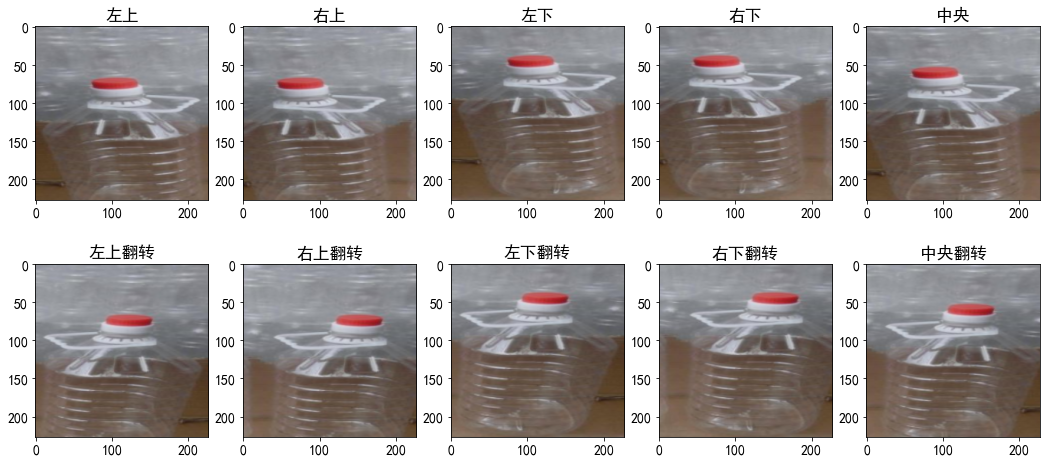

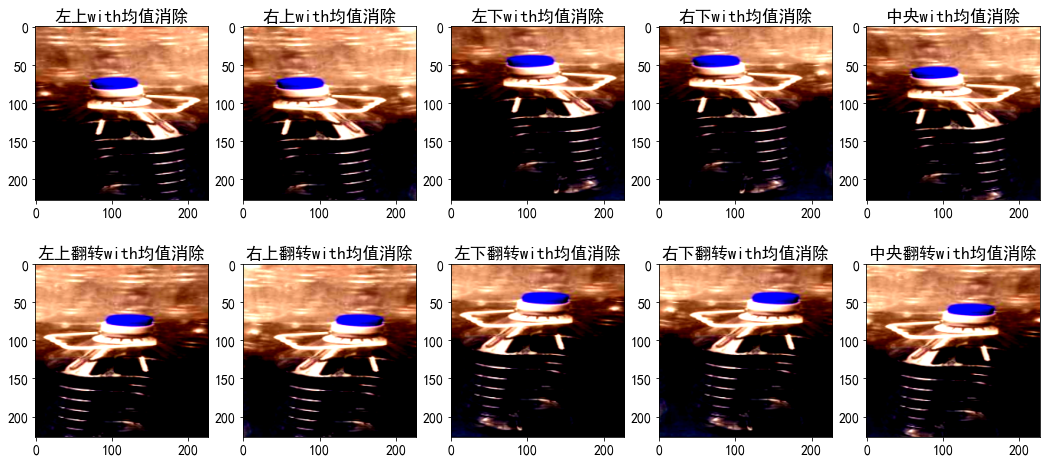

In [34]:
# pcodes00410_visualization
# 1. 可视化仅执行十重切割后的图像切片 [Q2-5.1]
# [Your codes 14.1]
plt.figure(1, figsize=(18, 8))




# 2. 可视化执行数据预处理后的图像切片 [Q2-5.2]
# [Your codes 14.2]
plt.figure(2, figsize=(18, 8))


